**An example of using [`Cue`]( https://github.com/yi-jia-li/cue) to predict nebular emission in prospector**

We provide three SPS classes in [nebssp_basis.py](https://github.com/yi-jia-li/prospector/tree/add_cue/prospect/sources/nebssp_basis.py) that use the nebular continuum and emission lines predicted by Cue. Previously, nebular emission was added within FSPS using the precomputed [`CloudyFSPS`](https://github.com/nell-byler/cloudyfsps) nebular grid, which was based on SSPs and included two free parameters: the ionization parameter U and the gas-phas metallicity O/H. Switching to Cue allows additional flexibility in modeling the ionizing spectrum, gas density, N/O, and C/O, where we model the ionizing spectrum with 4-piecewise power laws.

Dust attenuation and IGM absorption have been moved out of FSPS and are applied to the nebular emission in [fake_fsps.py](https://github.com/yi-jia-li/prospector/tree/add_cue/prospect/sources/fake_fsps.py). Dust emission has not yet been fully implemented.

In [1]:
# NebStepBasis and NebSSPBasis are adapted from FastStepBasis, SSPBasis to use Cue predictions
from prospect.sources.nebssp_basis import NebStepBasis, NebSSPBasis
import numpy as np
from matplotlib import pyplot as plt

from sedpy import observate
from prospect.observation import from_oldstyle
from prospect.models.templates import TemplateLibrary
from prospect.models.sedmodel import SpecModel

In [2]:
# Build obs with a wide wavelength grid
def build_obs(filts):
    obs = dict(filters=filts,
               wavelength=np.linspace(3000, 30000, 1000),
               spectrum=np.ones(1000),
               unc=np.ones(1000)*0.1,
               maggies=np.ones(len(filts))*1e-7,
               maggies_unc=np.ones(len(filts))*1e-8)
    sdat, pdat = from_oldstyle(obs)
    obslist = [sdat, pdat]
    [obs.rectify() for obs in obslist]
    return obslist

filters = observate.load_filters([f"sdss_{b}0" for b in "ugriz"])
obslist = build_obs(filters)

In [3]:
# Build SPS with cue SPS classes
def get_sps():
    sps = NebStepBasis(zcontinuous=1)
    return sps
sps = get_sps()

Cue parameters and their priors are in:
```py
TemplateLibrary["cue_stellar_nebular"]
TemplateLibrary["cue_nebular"]
```

Using the `cue_stellar_nebular` option fixes the ionizing sources to the stellar populations. In this case, we fit the ionizing spectra of the young and old stellar population to get the power-law parameters and the nebular emission is modeled with 5 free paramters: 
- gas_logu, gas_lognH, gas_logz, gas_logno, gas_logco.

Using the option `cue_nebular` fits the ionizing spectrum. In this case, the nebular emission is modeled with 13 free paramters: 
- 5 parameters for the gas properties (same as above)
- 8 parameters describing the ionizing radiation 
 - power-law index: ionspec_index1, ionspec_index2, ionspec_index3, ionspec_index4
 - ratios of luminosities between adjacent bins: ionspec_logLratio1, ionspec_logLratio2, ionspec_logLratio3
 - total ionizing photon output used to scale the cue prediction: gas_logqion

The option `use_eline_nn_unc` adds uncertainties from cue to the likelihood when fitting emission lines. This is set to False by default.

In [4]:
# Build a model with flexible SFH, dust, and nebular emission
model_pars = TemplateLibrary["continuity_sfh"]
model_pars["zred"]["init"] = 1.0
model_pars.update(TemplateLibrary["cue_stellar_nebular"])
model_pars["nebemlineinspec"]["init"] = False
model_pars['use_eline_nn_unc']["init"] = False
model = SpecModel(model_pars)
model

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0.],scale=[0.3 0.3],df=[2 2])
  gas_logz: <class 'prospect.models.priors.TopHat'>(mini=-2.2,maxi=0.5)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-4.0,maxi=-1.0)
  gas_lognH: <class 'prospect.models.priors.TopHat'>(mini=1.0,maxi=4.0)
  gas_logno: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.7323937598229685)
  gas_logco: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.7323937598229685)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [1.] 
  mass: [1000000.] <function logsfr_ratios_to_masses at 0x14c8eaa16440>
  sfh: [3] 
  imf_type: [2] 
  dust_type: [0] 
  agebins: [

In [5]:
# Model parameters
for k in model.params:
    print(k, model.params[k].squeeze())

zred 1.0
mass 1000000.0
logzsol -0.5
dust2 0.6
sfh 3
imf_type 2
dust_type 0
logmass 10
agebins [[ 0.  8.]
 [ 8.  9.]
 [ 9. 10.]]
logsfr_ratios [0. 0.]
add_neb_emission True
add_neb_continuum True
nebemlineinspec False
use_eline_nn_unc False
use_stellar_ionizing True
gas_logz 0.0
gas_logu -2.0
gas_lognH 2.0
gas_logno 0.0
gas_logco 0.0


In [6]:
model.predict(model.theta, obslist, sps)

([array([3.32612734e-11, 3.34332987e-11, 3.36741710e-11, 2.61985867e-11,
         3.72183178e-11, 3.29318925e-11, 3.48133953e-11, 3.61936374e-11,
         3.55829416e-11, 3.46668826e-11, 3.60668389e-11, 3.77962145e-11,
         3.72069220e-11, 3.67232955e-11, 3.85776440e-11, 3.79396438e-11,
         3.53451581e-11, 3.87719199e-11, 3.81363788e-11, 3.95781581e-11,
         3.82215038e-11, 3.96516886e-11, 4.09839238e-11, 4.02916679e-11,
         3.96793528e-11, 4.02172005e-11, 3.79197082e-11, 4.00367562e-11,
         4.12465081e-11, 3.83181872e-11, 4.06302829e-11, 4.06338984e-11,
         3.95996814e-11, 4.25258434e-11, 4.14917596e-11, 4.36387153e-11,
         4.25311757e-11, 4.13927101e-11, 4.22285448e-11, 4.32672487e-11,
         4.14802306e-11, 4.38709008e-11, 4.33839027e-11, 4.45115256e-11,
         4.38628090e-11, 4.37768526e-11, 4.57835886e-11, 4.43125782e-11,
         4.54587921e-11, 4.55901004e-11, 4.50646474e-11, 4.57683708e-11,
         4.66663216e-11, 4.51069787e-11, 4.58706219

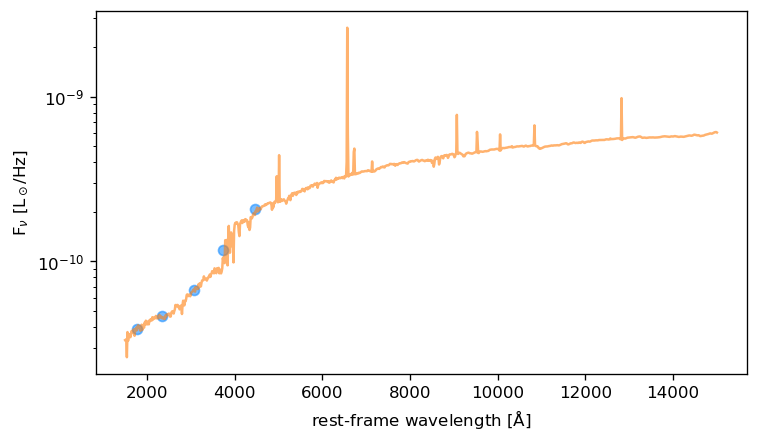

In [7]:
# Plot the predicted spectrum
plt.figure(figsize=(7,4), dpi=120)
plt.scatter(obslist[1].wavelength/(1+model.params['zred']), 
            model.predict(model.theta, obslist, sps)[0][1], color='dodgerblue', alpha=0.6)
plt.plot(obslist[0].wavelength/(1+model.params['zred']), 
         model.predict(model.theta, obslist, sps)[0][0], color='C1', alpha=0.6)
plt.yscale('log')
plt.xlabel(r'rest-frame wavelength [$\mathrm{\AA}$]')
plt.ylabel(r'F$_\nu$ [L$_\odot$/Hz]');

In [8]:
# Build a model with flexible SFH, dust, and nebular emission
model_pars = TemplateLibrary["continuity_sfh"]
model_pars["zred"]["init"] = 1.0
model_pars.update(TemplateLibrary["cue_nebular"])
model_pars["gas_logqion"]["init"] = 54.0 # set a high number of ionizing photons so the emission lines are stronger
model_pars["nebemlineinspec"]["init"] = False
model_pars['use_eline_nn_unc']["init"] = False
model = SpecModel(model_pars)
model

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0.],scale=[0.3 0.3],df=[2 2])
  gas_logz: <class 'prospect.models.priors.TopHat'>(mini=-2.2,maxi=0.5)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-4.0,maxi=-1.0)
  gas_lognH: <class 'prospect.models.priors.TopHat'>(mini=1.0,maxi=4.0)
  gas_logno: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.7323937598229685)
  gas_logco: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.7323937598229685)
  ionspec_index1: <class 'prospect.models.priors.TopHat'>(mini=1.0,maxi=42.0)
  ionspec_index2: <class 'prospect.models.priors.TopHat'>(mini=-0.3,maxi=30.0)
  ionspec_index3: <class 'prospect.models.priors.

In [9]:
# Model parameters
for k in model.params:
    print(k, model.params[k].squeeze())

zred 1.0
mass 1000000.0
logzsol -0.5
dust2 0.6
sfh 3
imf_type 2
dust_type 0
logmass 10
agebins [[ 0.  8.]
 [ 8.  9.]
 [ 9. 10.]]
logsfr_ratios [0. 0.]
add_neb_emission True
add_neb_continuum True
nebemlineinspec False
use_eline_nn_unc False
use_stellar_ionizing False
gas_logz 0.0
gas_logu -2.0
gas_lognH 2.0
gas_logno 0.0
gas_logco 0.0
ionspec_index1 3.3
ionspec_index2 15.0
ionspec_index3 8.0
ionspec_index4 3.0
ionspec_logLratio1 2.0
ionspec_logLratio2 1.0
ionspec_logLratio3 1.0
gas_logqion 54.0


In [10]:
model.predict(model.theta, obslist, sps)

([array([3.92276552e-11, 3.94952600e-11, 3.98244811e-11, 3.24312388e-11,
         4.35279956e-11, 3.93136769e-11, 4.12619944e-11, 4.27053006e-11,
         4.21535344e-11, 4.12933253e-11, 4.27457497e-11, 4.45245509e-11,
         4.39781132e-11, 4.35432257e-11, 4.54395411e-11, 4.48412502e-11,
         4.22846284e-11, 4.57469263e-11, 4.51452532e-11, 4.66193524e-11,
         4.52930274e-11, 4.67523400e-11, 4.81122574e-11, 4.74463599e-11,
         4.68590494e-11, 4.74209094e-11, 4.51465510e-11, 4.75766858e-11,
         4.85163164e-11, 4.56554481e-11, 4.78858821e-11, 4.79618418e-11,
         4.69455965e-11, 4.98890244e-11, 4.88720643e-11, 5.10361395e-11,
         4.99458720e-11, 4.88252080e-11, 4.96798883e-11, 5.07387883e-11,
         4.89740536e-11, 5.13829961e-11, 5.09230743e-11, 5.20769383e-11,
         5.14551616e-11, 5.13974146e-11, 5.34338001e-11, 5.19934563e-11,
         5.31713101e-11, 5.33359068e-11, 5.28454852e-11, 5.35858214e-11,
         5.45219925e-11, 5.30024792e-11, 5.38082629

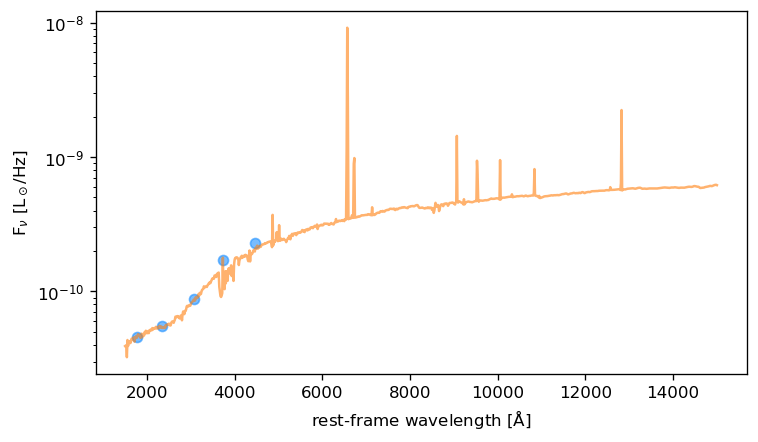

In [11]:
# Plot the predicted spectrum
plt.figure(figsize=(7,4), dpi=120)
plt.scatter(obslist[1].wavelength/(1+model.params['zred']), 
            model.predict(model.theta, obslist, sps)[0][1], color='dodgerblue', alpha=0.6)
plt.plot(obslist[0].wavelength/(1+model.params['zred']), 
         model.predict(model.theta, obslist, sps)[0][0], color='C1', alpha=0.6)
plt.yscale('log')
plt.xlabel(r'rest-frame wavelength [$\mathrm{\AA}$]')
plt.ylabel(r'F$_\nu$ [L$_\odot$/Hz]');